In [1]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.transforms as transform

import dataset

import pickle
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Some utility functions
#*************************************
def time_taken(elapsed):
    """To format time taken in hh:mm:ss. Use with time.monotic()"""
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

def mydate() :
    return (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

def save_obj(obj, name):
    with open(name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
# Read/write directory parameters
#*************************************
datadir = 'testing_data_release/testing_data'
loadmodelpath = 'new_model/2018-11-04_14-43-00_model_epoch3_step1080.pth'

# Pytorch parameters
#*************************************
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loadmodel = True

# Training parameters
#*************************************
batch_size = 1
log_interval = 5000

# Preprocessing parameters
#*************************************
bins = 48
hrange = 24

In [4]:
def load_files(filelist,code='0001'):
    files = [file for file in filelist if code in file]
    return files

def plot3d(P,L):
    
    plt.rcParams["figure.figsize"] = (20,12)
    fig = plt.figure()    
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(P[0], P[1], P[2], c='r', marker='o')
    ax.scatter(L[0], L[1], L[2], c='b', marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

['testing_data_release/testing_data\\0004_lig_cg.pdb'] ['testing_data_release/testing_data\\0001_pro_cg.pdb']


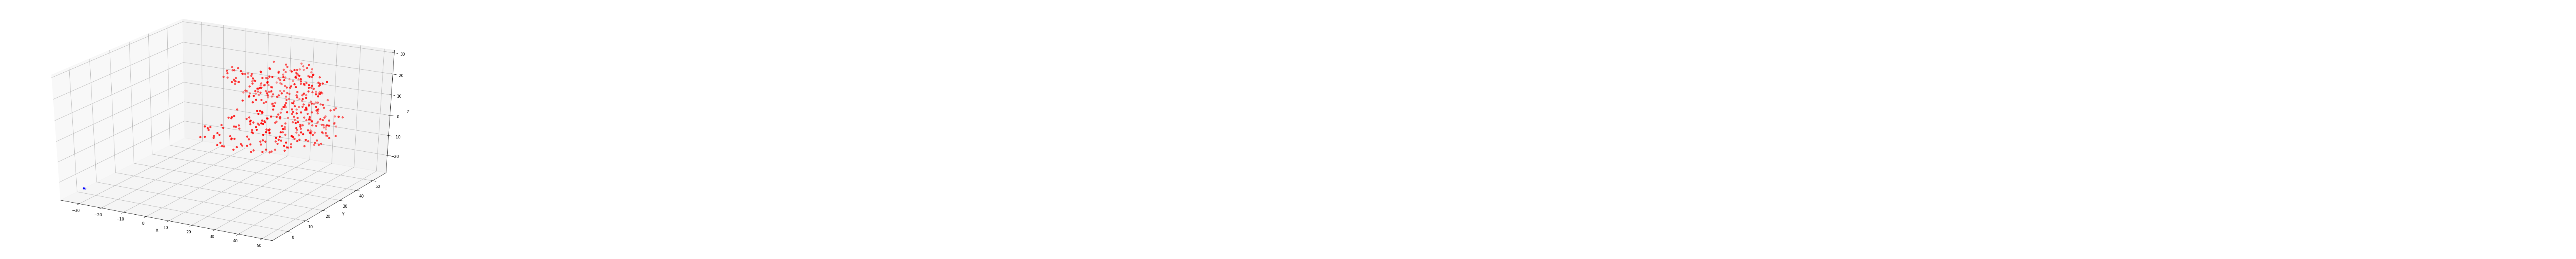

In [5]:
from mpl_toolkits.mplot3d import Axes3D

L_fileList, L_fnameList = dataset.listDirectory(datadir,'.pdb','lig')
P_fileList, P_fnameList = dataset.listDirectory(datadir,'.pdb','pro')
L_file = load_files(L_fileList,'0004')
P_file = load_files(P_fileList,'0001')
print(L_file,P_file)
P = dataset.read_pdb_test(P_file[0])
L = dataset.read_pdb_test(L_file[0])

plot3d(P,L)

In [7]:
# Initialize dataset & dataloader
#*************************************
adataset = dataset.ProLigDataset(datadir,split=False)

testdataset = dataset.miniDataset(dataset=adataset.all_pairs,mode='test',
                                        transform=transform.Compose([dataset.create_voxel2(bins=bins,hrange=hrange),dataset.array2tensor(torch.FloatTensor)]))

test_loader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=4,
                                          drop_last=False)

In [8]:
print("size of dataset is",len(testdataset))
print("no. of steps per epoch is",len(adataset)//batch_size)

for i in range(len(testdataset)):
    sample,target = testdataset[i]
    #plt.plot(sample['audio'])
    print(sample.shape)
    #print(target.shape)
    if i == 1:
        break
        
#print(adataset.all_pairs[0+824:824+824])

size of dataset is 238976
no. of steps per epoch is 678976
torch.Size([3, 48, 48, 48])
torch.Size([3, 48, 48, 48])


In [9]:
# Specify the model
#*************************************
class CNN(nn.Module):
    # input size - the number of "classes"
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=5, stride=1, padding=0),
            #nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(1024, 100),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.fc2 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        #print("in",x.shape)
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        out = self.fc1(out)
        #print(out.shape)
        out = self.fc2(out)
        out = self.sigmoid(out)
        #print(out.type())
        return out

In [10]:
def evaluate(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for step, (inp, _) in enumerate(test_loader):
            inp = inp.to(device)
            outputs = model(inp)
            #print(outputs)
            _, predicted = torch.max(outputs.data, 1)
            if predicted == 0:
                #print(inp[step])
                predictions.append(1)
            elif predicted == 1:
                predictions.append(0)
                
                if (step+1) % log_interval == 0:
                    print ('{:%Y-%m-%d %H:%M:%S} Step [{}/{}]'.format( 
        datetime.now(), step+1, len(testdataset)//batch_size))  
                    
def evaluate_mse(model):
    model.eval()
    with torch.no_grad():
        for step, (inp, _) in enumerate(test_loader):
            inp = inp.to(device)
            outputs = model(inp)
            outputs_numpy = outputs.detach().cpu().numpy()
            for i in range(outputs_numpy.shape[0]):
                predictions.append(outputs_numpy.item(i))

            if (step+1) % log_interval == 0:
                save_obj(predictions,"pred")
                print ('{:%Y-%m-%d %H:%M:%S} Step [{}/{}]'.format(datetime.now(), step+1, len(testdataset)//batch_size))  

In [11]:
# Initialize the network, optimizer and objective func
#*************************************
cnn = CNN().to(device)
if loadmodel: # load checkpoint if needed
    print("Loading existing checkpoint...")
    cnn.load_state_dict(torch.load(loadmodelpath))

Loading existing checkpoint...


In [12]:
# Predict!
#*************************************
predictions = []

print('{:%Y-%m-%d %H:%M:%S} Starting prediction...'.format(datetime.now()))
start_time = time.monotonic()
evaluate_mse(cnn)
elapsed_time = time.monotonic() - start_time
print('Testing time taken:',time_taken(elapsed_time))

2018-11-04 18:54:32 Starting prediction...
2018-11-04 18:54:54 Step [5000/238976]
2018-11-04 18:55:13 Step [10000/238976]
2018-11-04 18:55:36 Step [15000/238976]
2018-11-04 18:55:56 Step [20000/238976]
2018-11-04 18:56:16 Step [25000/238976]
2018-11-04 18:56:36 Step [30000/238976]
2018-11-04 18:56:56 Step [35000/238976]
2018-11-04 18:57:16 Step [40000/238976]
2018-11-04 18:57:35 Step [45000/238976]
2018-11-04 18:57:56 Step [50000/238976]
2018-11-04 18:58:16 Step [55000/238976]
2018-11-04 18:58:35 Step [60000/238976]
2018-11-04 18:58:57 Step [65000/238976]
2018-11-04 18:59:20 Step [70000/238976]
2018-11-04 18:59:42 Step [75000/238976]
2018-11-04 19:00:03 Step [80000/238976]
2018-11-04 19:00:25 Step [85000/238976]
2018-11-04 19:00:46 Step [90000/238976]
2018-11-04 19:01:07 Step [95000/238976]
2018-11-04 19:01:27 Step [100000/238976]
2018-11-04 19:01:49 Step [105000/238976]
2018-11-04 19:02:09 Step [110000/238976]
2018-11-04 19:02:32 Step [115000/238976]
2018-11-04 19:02:54 Step [120000/2

In [6]:
def out_format(predictions,dim,top):
    """predictions - list of output predictions
       dim - no of samples in dataset
       top - find top (number) of positive examples"""
    assert len(predictions) == dim**2
    pred_ = np.array(predictions)
    print(pred_[:dim])
    b = np.array(pred_).reshape((dim,dim))
    idx = (np.abs(b - 1))
    #print(idx)
    for row in range(idx.shape[0]):
        q = np.argpartition(idx[row], top)
        #print(q)
        count = 0
        for index in q:
            idx[row][index] = 1
            count += 1
            if count == top:
                break

    idx[idx!=1]=0
    #print(idx)
    print(idx.shape)
    idx = idx.reshape(dim**2)
    print(idx.shape)
    return list(idx)

pred = out_format(predictions,824,10)
print(pred[:824])
for i in pred[:824]:
    if i == 1:
        print(i) #just to confirm there are 10

[0.01901732 0.00760979 0.01008433 0.00808205 0.00765969 0.00757351
 0.00798715 0.00750911 0.00748893 0.00778186 0.00751859 0.00749573
 0.00775299 0.02395509 0.00869078 0.27625346 0.00721849 0.03907751
 0.0077744  0.01501277 0.0075523  0.0076744  0.00715081 0.00759989
 0.00758859 0.00693803 0.00790225 0.10468195 0.00764775 0.00811645
 0.01782852 0.01704033 0.00885399 0.00728892 0.01801747 0.23237383
 0.00753992 0.00725801 0.00826239 0.00993043 0.02165694 0.00767074
 0.00801472 0.00752063 0.00776188 0.02624678 0.11534712 0.5594787
 0.04727601 0.00766184 0.00796439 0.00767928 0.00765466 0.00758216
 0.02641065 0.00819588 0.00745721 0.00753836 0.02997566 0.85320312
 0.00915198 0.34895045 0.27695465 0.00897896 0.00879708 0.00717985
 0.00803064 0.11908126 0.01093553 0.00737627 0.01003195 0.01174526
 0.00821797 0.0079126  0.03193428 0.00761041 0.00903904 0.9363479
 0.00751768 0.00771628 0.00829285 0.01904804 0.00780082 0.00751328
 0.01162854 0.00758435 0.00782269 0.00758927 0.00765995 0.007715

In [68]:
# predictions
#*************************************
import pandas as pd

#print(len(adataset.all_pairs))
#save_obj(predictions,"pred")
#save_obj(adataset.all_pairs,"test_dataset")
#pred = load_obj("pred")
pairs = np.load('test_dataset.pkl')
#print(len(pairs))
result = pred 
#result = np.load('pred.pkl')
#print(len(result))
base=1
step=824
output=[]
output_step=[]
counter = 0
protein_numbers = range(1, 825)
output_dict = {}

for x in range(0,len(result)):
    if result[x] == 1.:
        output_step.append(str(pairs[x][1][34:38]).lstrip('0'))  #append the ligand number
        counter += 1
    if counter == 10 or x == step*base:
        if x == step*base:
            base += 1
        else:
            x = step*base-1
            base += 1
        #print(pairs[x])
        counter = 0
        output_step += ['NA']*(10-len(output_step))
        #print(output_step)
        output.append(output_step)
        output_step = []

output_dict.update({'pro_id': protein_numbers})
counter = 1
output_transposed = np.transpose(output)
#print(output_transposed.shape)

for x in output_transposed:
    output_dict.update({'lig'+str(counter)+'_id': x})
    #print(len(x))
    counter += 1

#print(output_dict)
output_panda = pd.DataFrame(data=output_dict)
output_panda.to_csv('test_predictions.txt', sep='\t',index=False, header=True)        
#print(output_panda)


('testing_data_release/testing_data\\0001_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_release/testing_data\\0002_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_release/testing_data\\0003_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_release/testing_data\\0004_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_release/testing_data\\0005_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_release/testing_data\\0006_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_release/testing_data\\0007_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_release/testing_data\\0008_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_release/testing_data\\0009_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_rele

('testing_data_release/testing_data\\0590_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_release/testing_data\\0591_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_release/testing_data\\0592_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_release/testing_data\\0593_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_release/testing_data\\0594_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_release/testing_data\\0595_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_release/testing_data\\0596_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_release/testing_data\\0597_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_release/testing_data\\0598_pro_cg.pdb', 'testing_data_release/testing_data\\0824_lig_cg.pdb')
('testing_data_rele